In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import xgboost
import sys
sys.path.append("./skynet/bf/src/scripts/")
import xgboost_ohlc
import utils
import numpy as np
import seaborn as sns
import talib
import datetime
import requests
import time
%matplotlib inline

pd.set_option('display.max_columns', 300)
pd.set_option('display.max_rows', 500)
pd.options.display.precision = 10

In [81]:
version = '3001'
rate = 0.00035
data_size=200000
data_columns = ['MACDS/O','RSI','ATR/O','Time','C/O','O-1/C','H/O','L/O']
target_column = 'Target_Over'
backtest_columns = ['Open','High','Low','Close']

In [9]:
five = pd.read_csv('skynet/bf/data/processed/min_five.csv')
five = utils.shaping_ohlc(five,data_columns+[target_column]+backtest_columns,over_rate=rate).dropna()
xgbc,predict,test,all_data = xgboost_ohlc.c_model_generate(version=version,ohlc=five,data_columns=data_columns,target_column=target_column,data_size=data_size)

/Users/yata/.pyenv/versions/3.8.0/lib/python3.8/site-packages/pandas/core/computation/expressions.py:177: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  warnings.warn(
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=1)]: Done  90 out of  90 | elapsed:  8.6min finished


0.587
Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  90 out of  90 | elapsed:  8.6min finished


In [16]:
five = pd.read_csv('skynet/bf/data/processed/min_five.csv')
five = utils.shaping_ohlc(five,data_columns+[target_column]+['Close'],over_rate=rate).dropna()

/Users/yata/.pyenv/versions/3.8.0/lib/python3.8/site-packages/pandas/core/computation/expressions.py:177: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  warnings.warn(


In [112]:
five_real = utils.get_ohlc(periods=300,datasize=5000,api_key=False)

0.6215435410647957


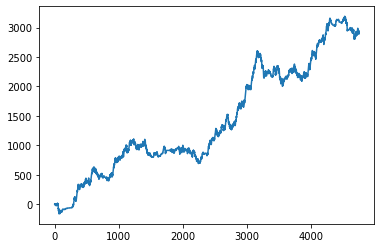

In [146]:
five_real = utils.get_ohlc(periods=300,datasize=5000,api_key=False)
five_real =  utils.shaping_ohlc(five_real,data_columns+[target_column]+backtest_columns,over_rate=rate).dropna()
real_predict = xgbc.predict(five_real[data_columns])

income = [0]
predict = real_predict
backtest = five_real
cnt = [0]
cnt2 = [0]
cnt3 = [0]
cnt4 = [0]
cnt5 = [0]
cnt6 = 0
gain = 6

print((predict == backtest['Target_Over']).mean())

for i in range(len(predict)-1):
    if predict[i] == 1 and backtest['Target_Over'].values[i] == 1:
        income.append(income[-1]+backtest['Close'].values[i]*rate*2*0.01)
        cnt.append(cnt[-1]+backtest['Close'].values[i]*rate*2*0.01)
    elif predict[i] == 1 and backtest['Target_Over'].values[i] == 0:
        if backtest['Close'].values[i]*(1-rate) <backtest['Low'].shift(-1).values[i] and backtest['High'].shift(-1).values[i] < backtest['Close'].values[i]*(1+rate):
            income.append(income[-1])
            cnt6  += 1
            
        elif backtest['Close'].values[i]*(1-rate) < backtest['Low'].shift(-1).values[i]:
            if backtest['High'].shift(-1).values[i] >= backtest['Close'].values[i]*(1+gain*rate):
                income.append(income[-1]-0.01*backtest['Close'].values[i]*rate*(gain-1))
                cnt2.append(cnt2[-1]-0.01*backtest['Close'].values[i]*rate*(gain-1)-1)
            else:
                income.append(income[-1]+0.01*(backtest['Close'].values[i]*(1+rate)-backtest['Close'].shift(-1).values[i]))
                cnt3.append(cnt3[-1]+0.01*(backtest['Close'].values[i]*(1+rate)-backtest['Close'].shift(-1).values[i]))
                
        elif backtest['High'].shift(-1).values[i] < backtest['Close'].values[i]*(1+rate):
            if backtest['Low'].shift(-1).values[i] <= backtest['Close'].values[i]*(1-gain*rate):
                income.append(income[-1]-0.01*backtest['Close'].values[i]*rate*(gain-1))
                cnt4.append(cnt4[-1]-0.01*backtest['Close'].values[i]*rate*(gain-1)-1)
            else:
                income.append(income[-1]+0.01*(backtest['Close'].shift(-1).values[i]-backtest['Close'].values[i]*(1-rate)))
                cnt5.append(cnt5[-1]+0.01*(backtest['Close'].shift(-1).values[i]-backtest['Close'].values[i]*(1-rate)))
    else:
        income.append(income[-1])
        
plt.plot(income)

In [121]:
cnt[-1]

23815.432424000024

In [129]:
cnt2[-1]

-5963.155716000001

In [130]:
cnt3[-1]

18.142741000026

In [131]:
cnt4[-1]

-5469.807504

In [132]:
cnt5[-1]

17.60677149998722

In [134]:
len(cnt2)+len(cnt4)

1085

In [136]:
len(cnt3)+len(cnt5)

52

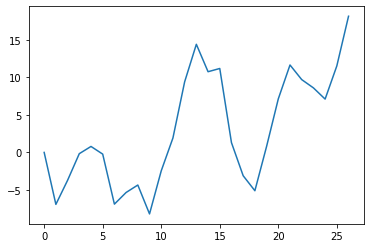

In [133]:
plt.plot(cnt3)

In [ ]:
income = [0]
backtest = five[-1000:]
cnt = 0
cnt2 = 0
for i in range(999):
    if predict[i] == 1 and backtest['Target_Over'].values[i] == 1:
        income.append(income[-1]+backtest['Close'].values[i+1]*rate*2*0.01)
        cnt += 1
    elif predict[i] == 1 and backtest['Target_Over'].values[i] == 0:
        income.append(income[-1]-backtest['Close'].values[i+1]*rate*2*0.01)
        cnt2 += 1
    else:
        income.append(income[-1])
        
plt.plot(income)

In [102]:
five = pd.read_csv("skynet/bf/data/processed/min_five.csv")[-200000:]

In [140]:
rate= 0.00035
five['In'] = ((five['Open']*(1+rate) <= five['High']) * (five['Open']*(1-rate) >= five['Low'])).shift(-1)
five['2In'] = ((five['Open']*(1+6*rate) <= five['High']) | (five['Open']*(1-6*rate) >= five['Low'])).shift(-1).astype(bool)
five['d2In'] = ((five['Open']*(1+2*rate) <= five['High']) * (five['Open']*(1-2*rate) >= five['Low'])).shift(-1)
five['pureIn'] = five['In'] * (~five['2In'])
five['pureIn2'] = five['In'] * (five['2In'])
print(five['In'].mean())
print(five['2In'].mean())
print(five['d2In'].mean())
print(five['pureIn'].mean())
print(five['pureIn2'].mean())

0.4788223941119706
0.311235
0.22896614483072417
0.29688648443242216
0.1819359096795484


In [142]:
five[five['In'] == True]['2In'].mean()

0.3799653314397895